In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

In [46]:
# Use GPU

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [47]:
ds = tfds.load('fashion_mnist', split='train')

In [48]:
ds.as_numpy_iterator().next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

# Visualize image

In [49]:
data_iter = ds.as_numpy_iterator()

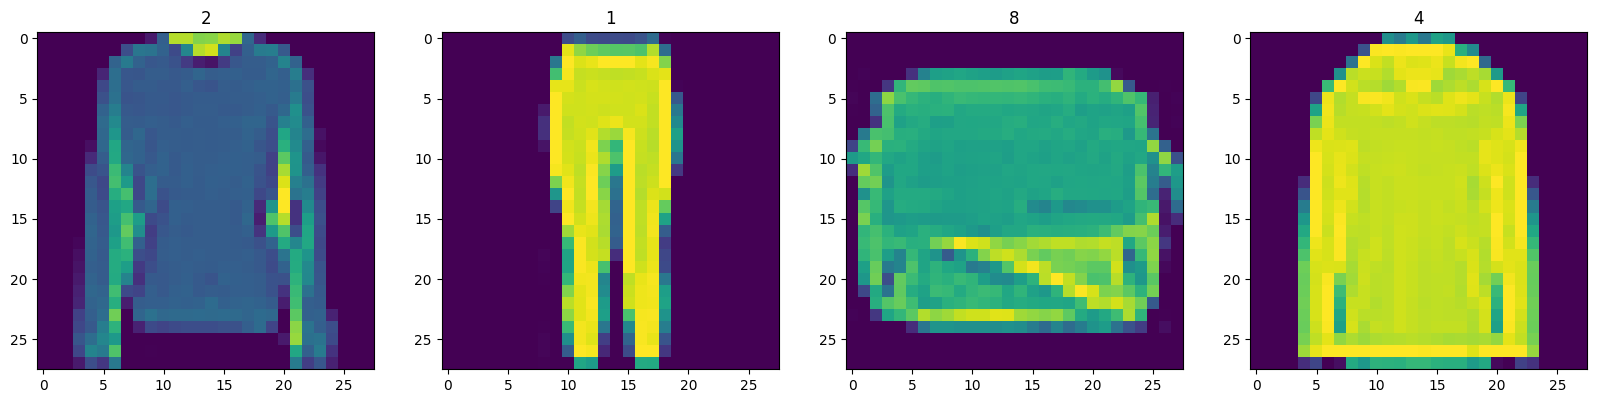

In [50]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    batch = data_iter.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [51]:
# Scale dataset
def scale(data):
    image = data['image']
    return image / 255

### Pipeline

In [52]:
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through scale preprocessing step
ds = ds.map(scale)

# Caches dataset for that batch
ds = ds.cache()

# Shuffle the dataset
ds = ds.shuffle(1000)

# Batch into 128 images per sample
ds = ds.batch(128)

# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [53]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# Build the model

In [54]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### Build Generator

In [55]:
def build_generator():
    model = Sequential()

    # Takes in random value and reshape it to 7x7x128
    # Beginings of a generator
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to one chanel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [56]:
generator = build_generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [57]:
img = generator.predict(np.random.randn(4,128,1))
img

1/1 [==============================] - 0s 92ms/step


array([[[[0.50642526],
         [0.5131804 ],
         [0.51608694],
         ...,
         [0.5094557 ],
         [0.50400406],
         [0.50096506]],

        [[0.5081812 ],
         [0.51220816],
         [0.51035756],
         ...,
         [0.5083483 ],
         [0.5048115 ],
         [0.50077194]],

        [[0.50647366],
         [0.5162703 ],
         [0.5253635 ],
         ...,
         [0.5129785 ],
         [0.5068829 ],
         [0.50257164]],

        ...,

        [[0.5013148 ],
         [0.50582457],
         [0.5084857 ],
         ...,
         [0.5113605 ],
         [0.50274324],
         [0.49949816]],

        [[0.5029428 ],
         [0.5034685 ],
         [0.50278413],
         ...,
         [0.50841117],
         [0.5006333 ],
         [0.4982991 ]],

        [[0.50116485],
         [0.50138336],
         [0.500785  ],
         ...,
         [0.49938017],
         [0.49625957],
         [0.49713904]]],


       [[[0.51569957],
         [0.5255785 ],
         [0.52

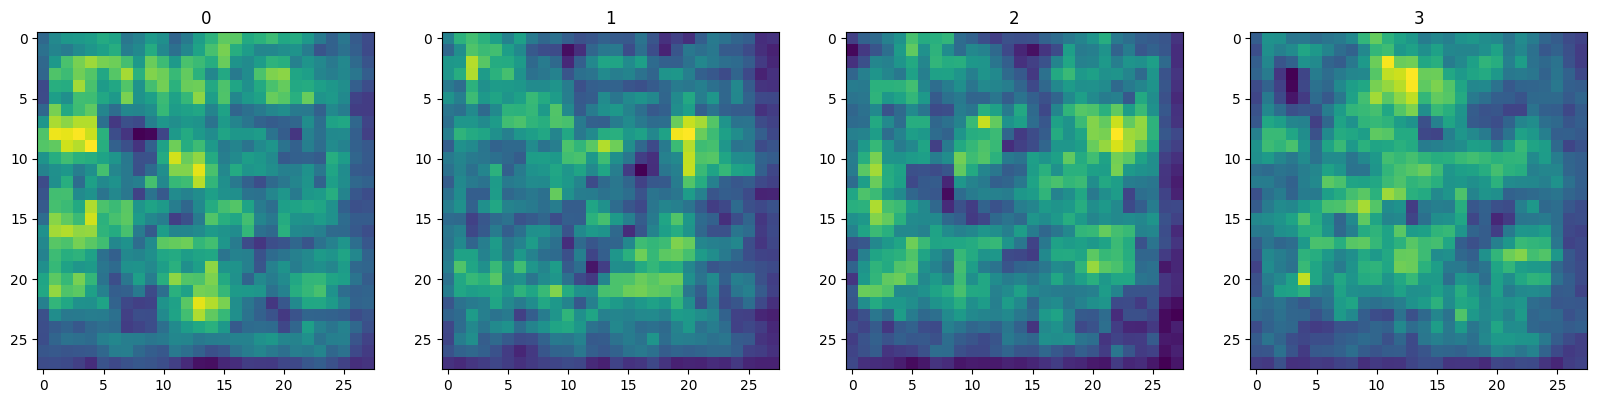

In [58]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx,img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

### Build Discriminator

In [59]:
def build_discriminator():
    model = Sequential()

    # Convolutional block 1
    model.add(Conv2D(32, 5, input_shape= (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Convolutional block 2
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Convolutional block 3
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Convolutional block 4
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to Dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [60]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)      

In [61]:
# img = img[0]
# discriminator.predict(img)

# Contruct Training loop

### Setup Losses and and Optimizers

In [62]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# setup optimizers
g_opt = Adam(learning_rate = 0.0001)
d_opt = Adam(learning_rate = 0.00001)

# setup losses
g_losses = BinaryCrossentropy()
d_losses = BinaryCrossentropy()


### Build Subclass Model

In [63]:
from tensorflow.keras import Model

In [64]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [65]:
# Create instance of subclass model
fashiongan = FashionGAN(generator, discriminator)

In [66]:
fashiongan.compile(g_opt, d_opt, g_losses, d_losses)

### Build CallBack

In [67]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [68]:
# from google.colab import drive
# drive.mount('/content/drive')

In [69]:
output_img = "/content/drive/MyDrive/Deep Learning with Tensorflow/GAN with Fashion Mnist dataset/images"
# os.makedirs(output_img, exist_ok=True)

In [70]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join(output_img, f'generated_img_{epoch}_{i}.png'))

### Training model

In [ ]:
history = fashiongan.fit(ds, epochs=200, callbacks=[ModelMonitor()])

Epoch 1/200
469/469 [==============================] - 84s 167ms/step - d_loss: 0.5323 - g_loss: 0.7637
Epoch 2/200
469/469 [==============================] - 77s 164ms/step - d_loss: 0.3519 - g_loss: 5.3486
Epoch 3/200
469/469 [==============================] - 77s 165ms/step - d_loss: 0.2799 - g_loss: 7.0860
Epoch 4/200
469/469 [==============================] - 77s 164ms/step - d_loss: 0.3078 - g_loss: 5.9524
Epoch 5/200
469/469 [==============================] - 77s 164ms/step - d_loss: 0.3340 - g_loss: 5.1257
Epoch 6/200
469/469 [==============================] - 77s 165ms/step - d_loss: 0.5165 - g_loss: 1.4222
Epoch 7/200
469/469 [==============================] - 78s 166ms/step - d_loss: 0.6554 - g_loss: 0.6204
Epoch 8/200
469/469 [==============================] - 78s 165ms/step - d_loss: 0.4517 - g_loss: 0.1865
Epoch 9/200
469/469 [==============================] - 78s 165ms/step - d_loss: 0.5608 - g_loss: 0.1864
Epoch 10/200
469/469 [==============================] - 78s 165m

In [1]:
plt.subtitle('Loss')
plt.plot(history.history['d_loss'], label='d_loss')
plt.plot(history.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

NameError: name 'plt' is not defined